# Lung Cancer Mortality Prediction

# CS5644: Machine Learning with Big Data Course Project

## Importing Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Metrics and Evaluation
from sklearn.metrics import (
    classification_report,
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# Other Utilities
from prettytable import PrettyTable
import featuretools as ft

# Ensure plots display inline in Jupyter Notebooks
%matplotlib inline


## Loading Dataset

In [6]:
# Load the data
df = pd.read_csv('Data/lung_cancer_mortality_featured.csv')

In [7]:
df.head()

,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,gender_Female,gender_Male,country_Austria,...,hypertension - other_cancer,hypertension - survived,other_cancer - survived,TIME_SINCE(beginning_of_treatment_date),TIME_SINCE(diagnosis_date),TIME_SINCE(end_treatment_date),YEAR(beginning_of_treatment_date),YEAR(diagnosis_date),YEAR(end_treatment_date),survived
0,64.0,31.1,257,1,1,0,0,True,False,False,...,1.0,1.0,0.0,2.673009e+08,2.685105e+08,2.177937e+08,2016,2016,2017,0
1,50.0,25.9,208,1,0,0,0,False,True,False,...,1.0,1.0,0.0,4.551207e+07,4.637607e+07,1.449447e+07,2023,2023,2024,0
2,65.0,18.9,193,0,0,0,0,False,True,False,...,0.0,0.0,0.0,4.724007e+07,4.767207e+07,-1.315353e+07,2023,2023,2025,0
3,51.0,34.6,249,1,1,1,0,True,False,False,...,1.0,0.0,-1.0,2.731761e+08,2.736945e+08,2.363697e+08,2016,2016,2017,1
4,37.0,40.2,262,0,0,0,0,False,True,False,...,0.0,0.0,0.0,2.693607e+07,2.710887e+07,1.707268e+06,2023,2023,2024,0


### A. Preprocessing

In [9]:
# Display basic information about the dataset
print("Basic Info:")
df.info()

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Columns: 225 entries, age to survived
dtypes: bool(49), float64(161), int64(15)
memory usage: 972.7 MB


In [10]:
# Checking missing values
print("\nMissing Values per Column:")
print(df.isna().sum().sort_values(ascending=False))


Missing Values per Column:
survived / other_cancer             498133
other_cancer / survived             498133
other_cancer / cirrhosis            495881
cirrhosis / other_cancer            495881
cirrhosis / survived                422587
                                     ...  
cholesterol_level + hypertension         0
cholesterol_level + other_cancer         0
cholesterol_level + survived             0
cirrhosis + hypertension                 0
survived                                 0
Length: 225, dtype: int64


In [11]:
# Display the number of unique values in each column
print("\nUnique Value Count per Column:")
print(df.nunique())


Unique Value Count per Column:
age                                    94
bmi                                   291
cholesterol_level                     151
hypertension                            2
asthma                                  2
                                     ... 
TIME_SINCE(end_treatment_date)       4192
YEAR(beginning_of_treatment_date)      11
YEAR(diagnosis_date)                   11
YEAR(end_treatment_date)               13
survived                                2
Length: 225, dtype: int64


In [12]:
# Checking for infinite values
print("\nInfinite Value Count per Column:")
infinite_counts = df.apply(lambda col: (col == float('inf')).sum() + (col == float('-inf')).sum())
print(infinite_counts[infinite_counts > 0])


Infinite Value Count per Column:
age / asthma                        371606
age / cirrhosis                     541542
age / hypertension                  174904
age / other_cancer                  638536
age / survived                      546178
asthma / cirrhosis                  246615
asthma / hypertension                65728
asthma / other_cancer               295647
asthma / survived                   256122
bmi / asthma                        371606
bmi / cirrhosis                     541542
bmi / hypertension                  174904
bmi / other_cancer                  638536
bmi / survived                      546178
cholesterol_level / asthma          371606
cholesterol_level / cirrhosis       541542
cholesterol_level / hypertension    174904
cholesterol_level / other_cancer    638536
cholesterol_level / survived        546178
cirrhosis / asthma                   76679
cirrhosis / hypertension             27280
cirrhosis / other_cancer            142655
cirrhosis / survived

In [13]:
# Identify columns with positive or negative infinite values
cols_with_infinite = df.columns[(df == float('inf')).any() | (df == float('-inf')).any()]

# Drop columns with infinite values
df_cleaned = df.drop(columns=cols_with_infinite)

# Print columns that were removed
print("Columns with infinite values removed:")
print(cols_with_infinite)

Columns with infinite values removed:
Index(['age / asthma', 'age / cirrhosis', 'age / hypertension',
       'age / other_cancer', 'age / survived', 'asthma / cirrhosis',
       'asthma / hypertension', 'asthma / other_cancer', 'asthma / survived',
       'bmi / asthma', 'bmi / cirrhosis', 'bmi / hypertension',
       'bmi / other_cancer', 'bmi / survived', 'cholesterol_level / asthma',
       'cholesterol_level / cirrhosis', 'cholesterol_level / hypertension',
       'cholesterol_level / other_cancer', 'cholesterol_level / survived',
       'cirrhosis / asthma', 'cirrhosis / hypertension',
       'cirrhosis / other_cancer', 'cirrhosis / survived',
       'hypertension / asthma', 'hypertension / cirrhosis',
       'hypertension / other_cancer', 'hypertension / survived',
       'other_cancer / asthma', 'other_cancer / cirrhosis',
       'other_cancer / hypertension', 'other_cancer / survived',
       'survived / asthma', 'survived / cirrhosis', 'survived / hypertension',
       'surviv

In [14]:
# Check for NaN values in the cleaned DataFrame
print("Null values in cleaned DataFrame:")
print(df_cleaned.isnull().sum())

Null values in cleaned DataFrame:
age                                  0
bmi                                  0
cholesterol_level                    0
hypertension                         0
asthma                               0
                                    ..
TIME_SINCE(end_treatment_date)       0
YEAR(beginning_of_treatment_date)    0
YEAR(diagnosis_date)                 0
YEAR(end_treatment_date)             0
survived                             0
Length: 190, dtype: int64


In [15]:
# Set target variable 'survived' as y
y = df_cleaned["survived"]

# Identify features related to "survived" (e.g., columns with "survived" in their names)
related_features = [col for col in df_cleaned.columns if "survived" in col.lower()]

# Remove features related to "survived" from x
x_cleaned = df_cleaned.drop(columns=related_features)

# Print the shapes of x and y
print(f"x_cleaned shape: {x_cleaned.shape}")
print(f"y shape: {y.shape}")

# Verify related features removed
print("Removed features related to 'survived':", related_features)


x_cleaned shape: (700000, 163)
y shape: (700000,)
Removed features related to 'survived': ['ABSOLUTE(survived)', 'age + survived', 'asthma + survived', 'bmi + survived', 'cholesterol_level + survived', 'cirrhosis + survived', 'hypertension + survived', 'other_cancer + survived', 'survived / age', 'survived / bmi', 'survived / cholesterol_level', 'age * survived', 'asthma * survived', 'bmi * survived', 'cholesterol_level * survived', 'cirrhosis * survived', 'hypertension * survived', 'other_cancer * survived', 'PERCENTILE(survived)', 'age - survived', 'asthma - survived', 'bmi - survived', 'cholesterol_level - survived', 'cirrhosis - survived', 'hypertension - survived', 'other_cancer - survived', 'survived']


In [16]:
# Check for missing values in x_cleaned
missing_values = x_cleaned.isnull().sum()

print(missing_values)

# Filter and display columns with missing values
columns_with_missing = missing_values[missing_values > 0]
print("Columns with missing values:")
print(columns_with_missing)


age                                  0
bmi                                  0
cholesterol_level                    0
hypertension                         0
asthma                               0
                                    ..
TIME_SINCE(diagnosis_date)           0
TIME_SINCE(end_treatment_date)       0
YEAR(beginning_of_treatment_date)    0
YEAR(diagnosis_date)                 0
YEAR(end_treatment_date)             0
Length: 163, dtype: int64
Columns with missing values:
Series([], dtype: int64)


Class Distribution in Target Variable:
survived
0    546178
1    153822
Name: count, dtype: int64

Class Percentages:
survived
0    78.025429
1    21.974571
Name: proportion, dtype: float64


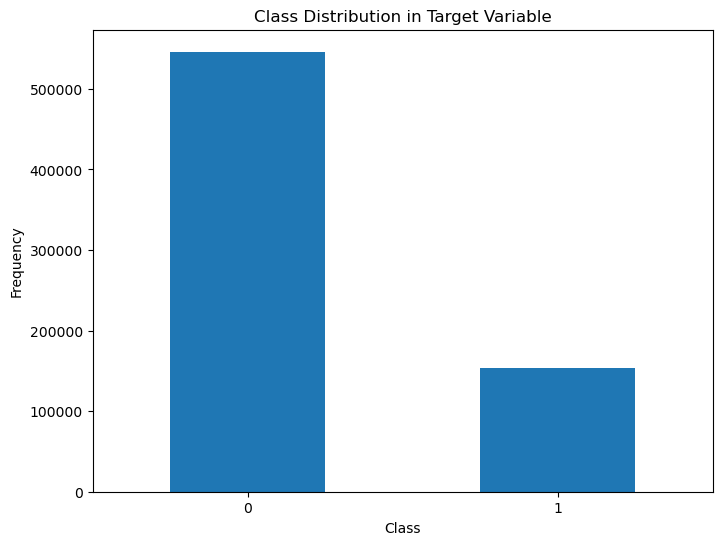

In [17]:
# Check class distribution in the target variable 'y'
class_distribution = y.value_counts()

# Calculate percentages
class_percentages = y.value_counts(normalize=True) * 100

# Print class distribution
print("Class Distribution in Target Variable:")
print(class_distribution)

print("\nClass Percentages:")
print(class_percentages)

# Visualize the class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title("Class Distribution in Target Variable")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


## Balancing the Class Imbalance using SMOTE

/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class Distribution After Balancing:
survived
0    546178
1    546178
Name: count, dtype: int64

Class Percentages After Balancing:
survived
0    50.0
1    50.0
Name: proportion, dtype: float64


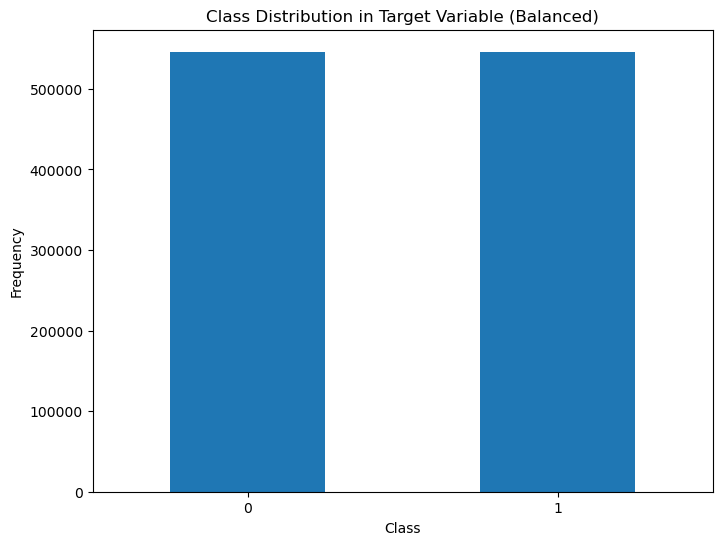

In [19]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# Apply SMOTE
smote = SMOTE(random_state=42, n_jobs=-1)  # Use all available cores for parallel processing
x_balanced, y_balanced = smote.fit_resample(x_cleaned, y)

# Convert y_balanced to a Pandas Series for easier analysis
y_balanced_series = pd.Series(y_balanced)

# Check class distribution after balancing
class_counts = y_balanced_series.value_counts()
class_percentages = y_balanced_series.value_counts(normalize=True) * 100

# Print class distribution and percentages
print("Class Distribution After Balancing:")
print(class_counts)
print("\nClass Percentages After Balancing:")
print(class_percentages)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title("Class Distribution in Target Variable (Balanced)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()



## Correlation heatmap 

Top 20 Features with Highest Correlations:
Index(['bmi * cholesterol_level', 'age - cholesterol_level', 'age / bmi',
       'age + cholesterol_level', 'bmi / age', 'asthma + bmi', 'asthma - bmi',
       'bmi + hypertension', 'bmi + cirrhosis', 'bmi - cirrhosis',
       'bmi - hypertension', 'bmi + cholesterol_level', 'bmi + other_cancer',
       'age * bmi', 'bmi - other_cancer', 'ABSOLUTE(bmi)', 'bmi',
       'PERCENTILE(bmi)', 'age / cholesterol_level', 'age - bmi'],
      dtype='object')


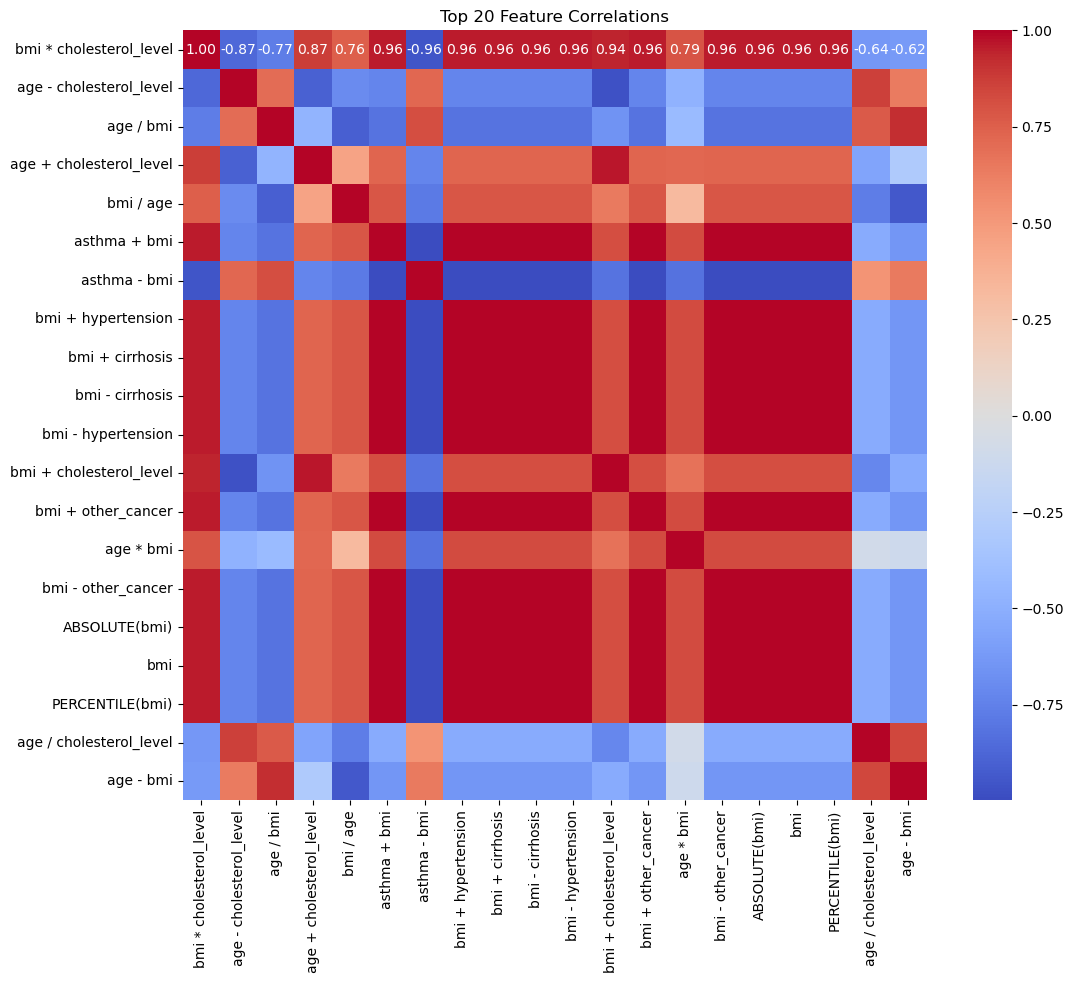

In [21]:


# Create a DataFrame from the balanced features
x_balanced_df = pd.DataFrame(x_balanced, columns=x_cleaned.columns)

# Compute the correlation matrix
correlation_matrix = x_balanced_df.corr()

# Summarize correlations (absolute sum for each column)
correlation_sums = correlation_matrix.abs().sum().sort_values(ascending=False)

# Get the top 20 columns
top_20_columns = correlation_sums.head(20).index
print("Top 20 Features with Highest Correlations:")
print(top_20_columns)

# Filter the correlation matrix for the top 20 columns
top_20_correlation_matrix = correlation_matrix.loc[top_20_columns, top_20_columns]

# Plot the heatmap for the top 20 features
plt.figure(figsize=(12, 10))
sns.heatmap(top_20_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Top 20 Feature Correlations")
plt.show()


## B. Implementing Feature Importance

Top 20 Features Based on Importance:
                        Feature  Importance
130          PERCENTILE(asthma)    0.023493
7                 gender_Female    0.021277
51             ABSOLUTE(asthma)    0.018311
145       asthma - hypertension    0.018060
41           family_history_Yes    0.017968
134    PERCENTILE(hypertension)    0.017783
40            family_history_No    0.017696
66        asthma + hypertension    0.017689
117       asthma * hypertension    0.015391
108                age * asthma    0.014800
8                   gender_Male    0.014796
65           asthma + cirrhosis    0.014585
55       ABSOLUTE(hypertension)    0.013663
115  asthma * cholesterol_level    0.012571
94           hypertension / bmi    0.012565
85   asthma / cholesterol_level    0.012471
121          bmi * hypertension    0.012158
146       asthma - other_cancer    0.012055
114                asthma * bmi    0.012031
144          asthma - cirrhosis    0.011376


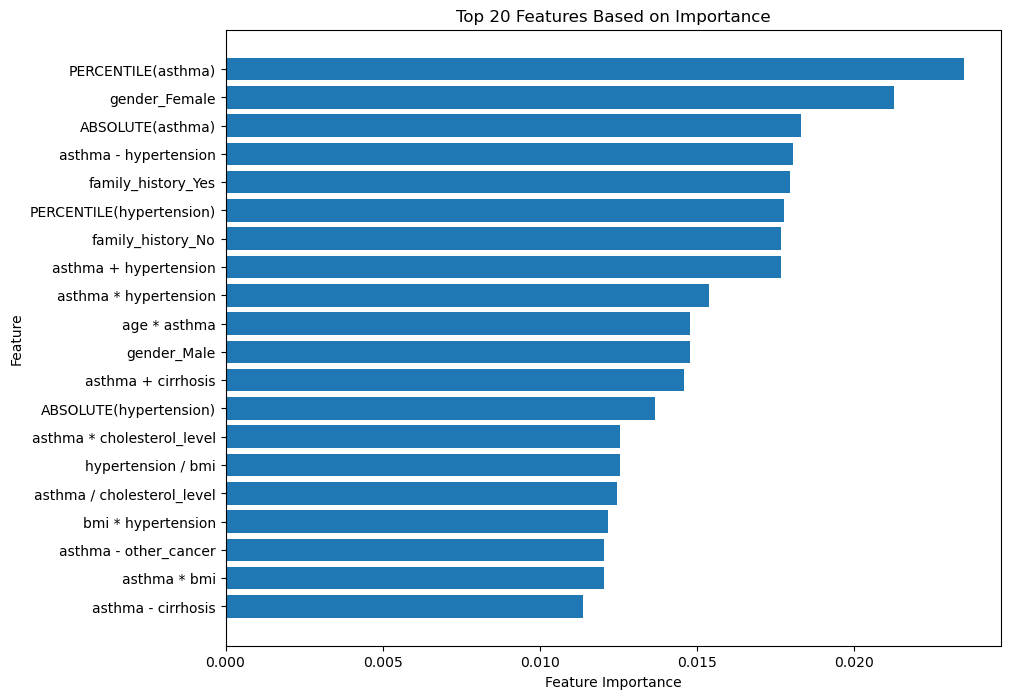

In [23]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(x_balanced, y_balanced)

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': x_balanced.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 20 features
top_features = feature_importances.head(20)
print("Top 20 Features Based on Importance:")
print(top_features)

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.title("Top 20 Features Based on Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


## Training on Various ML Algorithms

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Extract the names of the top 20 features
selected_features = top_features['Feature']

# Create feature set with the selected features
x_top_features = x_balanced[selected_features]

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_top_features)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_balanced, test_size=0.3, random_state=42)

# Print shapes for confirmation
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

# Evaluate Decision Tree
y_pred_dt = dt_model.predict(x_test)
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt))

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(x_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(x_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(x_train, y_train)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(x_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

# Evaluate Naive Bayes
y_pred_nb = nb_model.predict(x_test)
print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb))

# Train XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  
xgb_model.fit(x_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(x_test)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

# Train K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(x_train, y_train)

# Evaluate KNN
y_pred_knn = knn_model.predict(x_test)
print("K-Nearest Neighbors (KNN) Performance:")
print(classification_report(y_test, y_pred_knn))

# Train Artificial Neural Network (ANN)
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
ann_model.fit(x_train, y_train)

# Evaluate ANN
y_pred_ann = ann_model.predict(x_test)
print("ANN Performance:")
print(classification_report(y_test, y_pred_ann))


x_train shape: (764649, 20)
x_test shape: (327707, 20)
y_train shape: (764649,)
y_test shape: (327707,)
Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82    163615
           1       0.87      0.74      0.80    164092

    accuracy                           0.81    327707
   macro avg       0.82      0.81      0.81    327707
weighted avg       0.82      0.81      0.81    327707

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86    163615
           1       0.95      0.71      0.82    164092

    accuracy                           0.84    327707
   macro avg       0.86      0.84      0.84    327707
weighted avg       0.86      0.84      0.84    327707

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81    163615
           1       1.00      0.54      0.70   

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    163615
           1       1.00      0.70      0.82    164092

    accuracy                           0.85    327707
   macro avg       0.88      0.85      0.85    327707
weighted avg       0.88      0.85      0.85    327707

K-Nearest Neighbors (KNN) Performance:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84    163615
           1       0.91      0.71      0.80    164092

    accuracy                           0.82    327707
   macro avg       0.84      0.82      0.82    327707
weighted avg       0.84      0.82      0.82    327707

ANN Performance:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86    163615
           1       1.00      0.69      0.81    164092

    accuracy                           0.84    327707
   macro avg       0.88      0.84      0.84    3277

## Ploting important Graphs

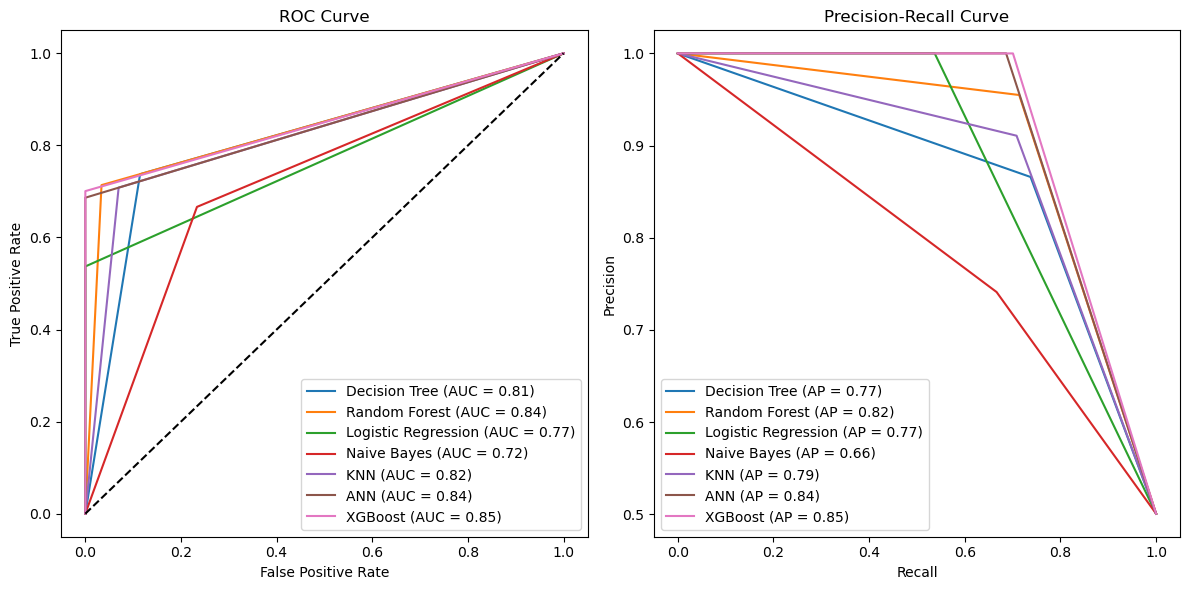

In [27]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# List of models and their predictions
models = {
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "KNN": y_pred_knn,
    "ANN": y_pred_ann,
    "XGBoost": y_pred_xgb
}

# Iterate through each model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # For ROC Curve
for model_name, y_pred in models.items():
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)  # For Precision-Recall Curve
for model_name, y_pred in models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=1)
    avg_precision = average_precision_score(y_test, y_pred)
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


## C. Implementing PCA

Number of components selected to retain 95% variance: 53
Explained variance ratio for each component:
[0.17423438 0.09242601 0.09023247 0.07460226 0.07083361 0.06247054
 0.03666318 0.03403215 0.01343556 0.01085962 0.01040492 0.01040273
 0.00897127 0.00845391 0.00777743 0.00774248 0.00773106 0.00771507
 0.00769211 0.0076578  0.00740611 0.0073387  0.00639313 0.00638025
 0.00637164 0.00636512 0.00636193 0.00635889 0.00635535 0.00634812
 0.00634554 0.00634397 0.00634084 0.00633772 0.00633631 0.00632837
 0.00632532 0.00632196 0.00632099 0.00631763 0.00631224 0.00630904
 0.00630697 0.00630546 0.00630045 0.00629505 0.00629175 0.00628838
 0.00627011 0.0062078  0.00606578 0.00590247 0.00587791]
Cumulative explained variance:
[0.17423438 0.26666039 0.35689286 0.43149513 0.50232873 0.56479927
 0.60146245 0.6354946  0.64893016 0.65978979 0.67019471 0.68059744
 0.68956871 0.69802262 0.70580005 0.71354253 0.72127359 0.72898865
 0.73668076 0.74433856 0.75174467 0.75908337 0.7654765  0.77185675
 0.778

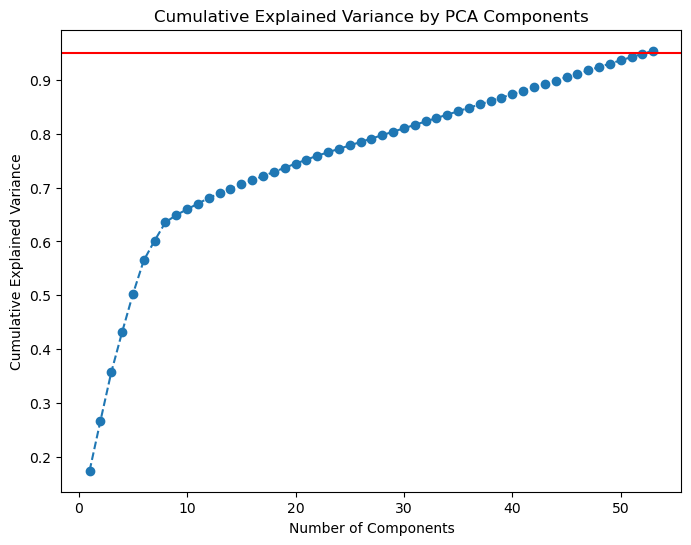

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
x_balanced_scaled = scaler.fit_transform(x_balanced)

# Perform PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
x_pca = pca.fit_transform(x_balanced_scaled)

# Number of components selected
num_components = pca.n_components_

print(f"Number of components selected to retain 95% variance: {num_components}")

# Optional: Show explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio for each component:")
print(explained_variance)

# Optional: Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("Cumulative explained variance:")
print(cumulative_variance)

# Visualize cumulative variance explained
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


## Training on various ML Algorithms

In [31]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_balanced, test_size=0.3, random_state=42)

# Print shapes for confirmation
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

# Evaluate Decision Tree
y_pred_dt_pca = dt_model.predict(x_test)
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt_pca))

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(x_train, y_train)

# Evaluate Random Forest
y_pred_rf_pca = rf_model.predict(x_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf_pca))

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(x_train, y_train)

# Evaluate Logistic Regression
y_pred_lr_pca = lr_model.predict(x_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr_pca))

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

# Evaluate Naive Bayes
y_pred_nb_pca = nb_model.predict(x_test)
print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb_pca))

# Train XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  
xgb_model.fit(x_train, y_train)

# Evaluate XGBoost
y_pred_xgb_pca = xgb_model.predict(x_test)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb_pca))

# Train K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(x_train, y_train)

# Evaluate KNN
y_pred_knn_pca = knn_model.predict(x_test)
print("K-Nearest Neighbors (KNN) Performance:")
print(classification_report(y_test, y_pred_knn_pca))

# Train Artificial Neural Network (ANN)
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
ann_model.fit(x_train, y_train)

# Evaluate ANN
y_pred_ann_pca = ann_model.predict(x_test)
print("ANN Performance:")
print(classification_report(y_test, y_pred_ann_pca))


x_train shape: (764649, 53)
x_test shape: (327707, 53)
y_train shape: (764649,)
y_test shape: (327707,)
Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77    163615
           1       0.76      0.78      0.77    164092

    accuracy                           0.77    327707
   macro avg       0.77      0.77      0.77    327707
weighted avg       0.77      0.77      0.77    327707

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87    163615
           1       1.00      0.72      0.83    164092

    accuracy                           0.86    327707
   macro avg       0.89      0.86      0.85    327707
weighted avg       0.89      0.86      0.85    327707

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78    163615
           1       0.79      0.74      0.76   

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87    163615
           1       1.00      0.72      0.83    164092

    accuracy                           0.86    327707
   macro avg       0.89      0.86      0.85    327707
weighted avg       0.89      0.86      0.85    327707

K-Nearest Neighbors (KNN) Performance:
              precision    recall  f1-score   support

           0       0.73      0.92      0.82    163615
           1       0.90      0.66      0.76    164092

    accuracy                           0.79    327707
   macro avg       0.81      0.79      0.79    327707
weighted avg       0.81      0.79      0.79    327707

ANN Performance:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87    163615
           1       1.00      0.72      0.83    164092

    accuracy                           0.86    327707
   macro avg       0.89      0.86      0.85    3277

## Ploting important graphs

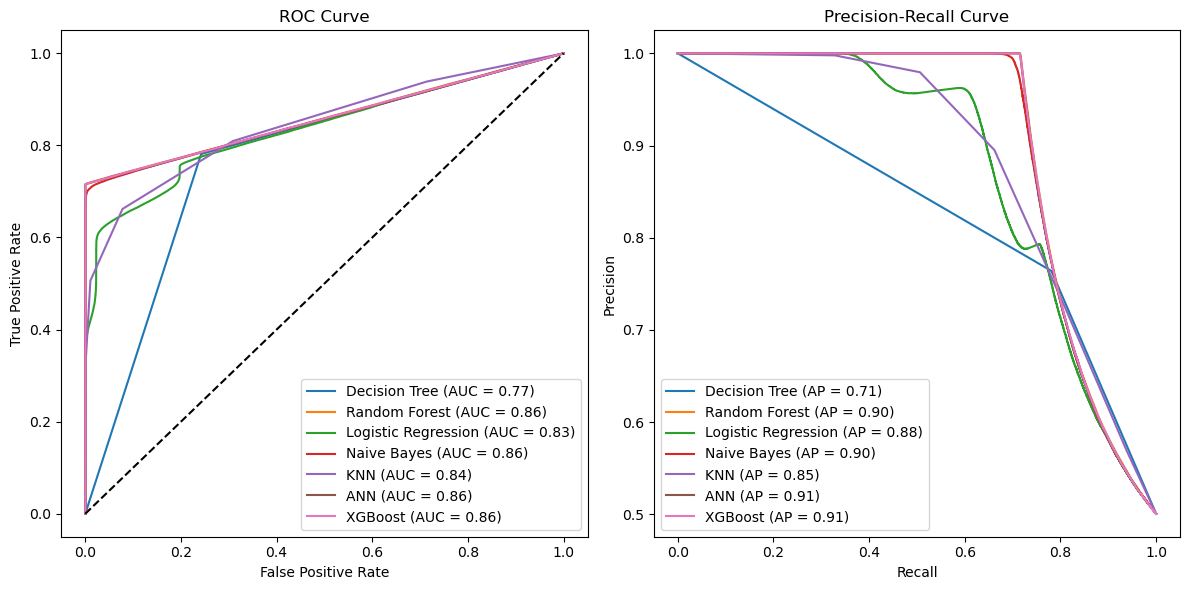

In [33]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Ensure predictions are probabilities for models that support it
y_pred_proba_dt = dt_model.predict_proba(x_test)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(x_test)[:, 1]
y_pred_proba_lr = lr_model.predict_proba(x_test)[:, 1]
y_pred_proba_nb = nb_model.predict_proba(x_test)[:, 1]
y_pred_proba_knn = knn_model.predict_proba(x_test)[:, 1]
y_pred_proba_ann = ann_model.predict_proba(x_test)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(x_test)[:, 1]

# Define models and probabilities for iteration
models_probas = {
    "Decision Tree": y_pred_proba_dt,
    "Random Forest": y_pred_proba_rf,
    "Logistic Regression": y_pred_proba_lr,
    "Naive Bayes": y_pred_proba_nb,
    "KNN": y_pred_proba_knn,
    "ANN": y_pred_proba_ann,
    "XGBoost": y_pred_proba_xgb,
}

# ROC Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Left subplot for ROC curve
for model_name, y_pred_proba in models_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)  # Right subplot for Precision-Recall curve
for model_name, y_pred_proba in models_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


## D. Comparing both dimentionality reduction techniques with their repspective ML algorithm results

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prettytable import PrettyTable
import pandas as pd

# Function to calculate and return performance metrics
def evaluate_model(y_test, y_pred, model_name, method):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")  
    recall = recall_score(y_test, y_pred, average="binary")
    f1 = f1_score(y_test, y_pred, average="binary")
    return {
        "Model": model_name,
        "Method": method,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Collect results for Feature Importance
results = []

# Feature Importance results
results.append(evaluate_model(y_test, y_pred_dt, "Decision Tree", "Feature Importance"))
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest", "Feature Importance"))
results.append(evaluate_model(y_test, y_pred_lr, "Logistic Regression", "Feature Importance"))
results.append(evaluate_model(y_test, y_pred_nb, "Naive Bayes", "Feature Importance"))
results.append(evaluate_model(y_test, y_pred_knn, "KNN", "Feature Importance"))
results.append(evaluate_model(y_test, y_pred_ann, "ANN", "Feature Importance"))
results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost", "Feature Importance"))

# PCA results
results.append(evaluate_model(y_test, y_pred_dt_pca, "Decision Tree", "PCA"))
results.append(evaluate_model(y_test, y_pred_rf_pca, "Random Forest", "PCA"))
results.append(evaluate_model(y_test, y_pred_lr_pca, "Logistic Regression", "PCA"))
results.append(evaluate_model(y_test, y_pred_nb_pca, "Naive Bayes", "PCA"))
results.append(evaluate_model(y_test, y_pred_knn_pca, "KNN", "PCA"))
results.append(evaluate_model(y_test, y_pred_ann_pca, "ANN", "PCA"))
results.append(evaluate_model(y_test, y_pred_xgb_pca, "XGBoost", "PCA"))

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Method", "Accuracy", "Precision", "Recall", "F1 Score"]

# Add rows to the table
for _, row in results_df.iterrows():
    table.add_row([
        row["Model"],
        row["Method"],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1 Score']:.4f}"
    ])

# Print the PrettyTable
print("Model Comparison Table: Feature Importance vs PCA")
print(table)

# Find the best combination based on F1 score
best_model = results_df.sort_values(by="F1 Score", ascending=False).iloc[0]
print("\nBest Combination:")
print(f"Model: {best_model['Model']}")
print(f"Method: {best_model['Method']}")
print(f"F1 Score: {best_model['F1 Score']:.4f}")


Model Comparison Table: Feature Importance vs PCA
+---------------------+--------------------+----------+-----------+--------+----------+
|        Model        |       Method       | Accuracy | Precision | Recall | F1 Score |
+---------------------+--------------------+----------+-----------+--------+----------+
|    Decision Tree    | Feature Importance |  0.8114  |   0.8659  | 0.7375 |  0.7966  |
|    Random Forest    | Feature Importance |  0.8398  |   0.9548  | 0.7138 |  0.8169  |
| Logistic Regression | Feature Importance |  0.7682  |   1.0000  | 0.5371 |  0.6988  |
|     Naive Bayes     | Feature Importance |  0.7164  |   0.7411  | 0.6665 |  0.7018  |
|         KNN         | Feature Importance |  0.8191  |   0.9107  | 0.7083 |  0.7968  |
|         ANN         | Feature Importance |  0.8430  |   1.0000  | 0.6864 |  0.8140  |
|       XGBoost       | Feature Importance |  0.8501  |   0.9999  | 0.7007 |  0.8240  |
|    Decision Tree    |        PCA         |  0.7696  |   0.7640  | 0.